# Label all GBH news articles using embedding similarity
Created annd maintained by Dingyuan Xu dyxu@bu.edu

In [1]:
import pandas as pd
import json
import openai
from transformers import pipeline

### This is an attempt to remove BERTopic from the pipeline and test model prediction on pure embedding similarity-based approach. 

In [2]:
# 230 topics from BERTopic
selected_topics_df = pd.read_csv("../openai_label_file/embedding_similarity_label.csv")

In [2]:
# Load GBH articles
unseen_articles = pd.read_csv('../datasets/Articles Nov 2020 - March 2023.csv', usecols=range(12))
unseen_articles = unseen_articles.dropna(subset=['Body'])
unseen_articles = unseen_articles.sample(n=5000, random_state=1)
unseen_articles.reset_index(drop=True, inplace=True)

In [26]:
# Independent cell to define embedding function

openai.api_key = # GitHub version does not include the OpenAI API key, please replace with your own key

import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, model="text-embedding-ada-002") -> list[float]:
    # print(text)
    return openai.Embedding.create(input=text, model=model)["data"][0]["embedding"]

In [4]:
# News body preprocessing, gets rid of html tags
from bs4 import BeautifulSoup
import re
# Function to get the first 500 elements from a list
def truncate(tokens, length=500):
    return tokens[:length]

unseen_articles['Body'] = unseen_articles['Body'].apply(lambda x: re.sub(re.compile('<.*?>'), '', x))
unseen_articles['tokens'] = unseen_articles['Body'].apply(lambda x: x.split())
unseen_articles['tokens'] = unseen_articles['tokens'].apply(truncate)

print(max(len(row['tokens']) for _, row in unseen_articles.iterrows()))

unseen_articles['ada_embedding'] = unseen_articles.tokens.apply(lambda x: get_embedding(','.join(map(str,x)), model='text-embedding-ada-002'))

print(unseen_articles.head(5))

0    Every season, the Drama After Dark team gather...
1    This week on Open Studio, Jared Bowen sits dow...
2    On a recent winter Tuesday just off Boston’s S...
3    David Prowse, the British weightlifting champi...
4    DETROIT (AP) — President Donald Trump summoned...
Name: Body, dtype: object
500
      Type                                              Label  \
0  Article  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Article  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Article  Infrastructure bills are kicking off billions ...   
3  Article  David Prowse, Actor Behind Darth Vader, Dies A...   
4  Article  President Trump Invites Michigan GOP Leaders T...   

                                            Headline  \
0  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Infrastructure bills are kicking off billions ...   
3  David Prowse, Actor Behind Darth Vader, Dies A...   
4  President Trump Invit

In [27]:
# Get the embedding for taxonomy
taxonomy_df = pd.read_csv('../datasets/Content_Taxonomy.csv', skiprows=5, usecols=range(8))
taxonomy_df.columns = taxonomy_df.iloc[0]
taxonomy_df = taxonomy_df.tail(-1)

tier_1_list = []
tier_2_list = []
tier_3_list = []
tier_4_list = []
for index, row in taxonomy_df.iterrows():
    if not pd.isnull(row['Tier 4']) and row['Tier 4'] != ' ':
        tier_1_label = row['Tier 1']
        tier_2_label = row['Tier 2']
        tier_3_label = row['Tier 3']
        tier_4_label = row['Tier 4']
        tier_4_list.append(f'{tier_1_label} - {tier_2_label} - {tier_3_label} - {tier_4_label}')
    elif not pd.isnull(row['Tier 3']) and row['Tier 3'] != ' ':
        tier_1_label = row['Tier 1']
        tier_2_label = row['Tier 2']
        tier_3_label = row['Tier 3']
        tier_3_list.append(f'{tier_1_label} - {tier_2_label} - {tier_3_label}')
    elif not pd.isnull(row['Tier 2']) and row['Tier 2'] != ' ':
        tier_1_label = row['Tier 1']
        tier_2_label = row['Tier 2']
        tier_2_list.append(f'{tier_1_label} - {tier_2_label}')
    else:
        tier_1_label = row['Tier 1']
        tier_1_list.append(f'{tier_1_label}')

tier_1_list = list(set(tier_1_list))
tier_2_list = list(set(tier_2_list))
tier_3_list = list(set(tier_3_list))
tier_4_list = list(set(tier_4_list))

tier_1_embedding = [get_embedding(topic) for topic in tier_1_list]
tier_2_embedding = [get_embedding(topic) for topic in tier_2_list]
tier_3_embedding = [get_embedding(topic) for topic in tier_3_list]
tier_4_embedding = [get_embedding(topic) for topic in tier_4_list]

all_topics_list = []
[all_topics_list.append(topic) for topic in tier_1_list]
[all_topics_list.append(topic) for topic in tier_2_list]
[all_topics_list.append(topic) for topic in tier_3_list]
[all_topics_list.append(topic) for topic in tier_4_list]

all_topics_embedding = []
[all_topics_embedding.append(embedding) for embedding in tier_1_embedding]
[all_topics_embedding.append(embedding) for embedding in tier_2_embedding]
[all_topics_embedding.append(embedding) for embedding in tier_3_embedding]
[all_topics_embedding.append(embedding) for embedding in tier_4_embedding]
print(len(all_topics_embedding))

703


In [28]:
# Get embedding for the 230 topics selected by BERTopic 
selected_taxonomy_df = pd.read_csv('../openai_label_file/embedding_similarity_label.csv')
selected_taxonomy_df = selected_taxonomy_df.dropna(subset=['closest_topic'])
selected_topics_list = selected_taxonomy_df['closest_topic'].values.tolist()
# print(all_topics_list)

selected_topics_embedding = [get_embedding(topic) for topic in selected_topics_list]

In [29]:
# Find most similar taxonomy to the BOW representations

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

closest_topic_list_all = []
for index, row in unseen_articles.iterrows():
    target_embedding = row['ada_embedding']
    similarities = [cosine_similarity(np.array(target_embedding).reshape(1, -1), np.array(topic).reshape(1, -1))[0][0] for topic in all_topics_embedding]

    # Find the index of the topic with the highest similarity
    closest_topic_index = np.argmax(similarities)

    # Retrieve the closest topic embedding
    closest_topic = all_topics_list[closest_topic_index]
    closest_topic_list_all.append(closest_topic)

unseen_articles['closest_topic_all'] = closest_topic_list_all
print(unseen_articles.head(10))

      Type                                              Label  \
0  Article  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Article  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Article  Infrastructure bills are kicking off billions ...   
3  Article  David Prowse, Actor Behind Darth Vader, Dies A...   
4  Article  President Trump Invites Michigan GOP Leaders T...   
5  Article  Japan Society Of Boston Marks Ten Years Since ...   
6  Article  U.S. Soccer paying millions in back pay to fem...   
7  Article  In living color: The Obama portraits come to B...   
8  Article  Arts This Week: A Public Art Exhibit On The Co...   
9  Article  RadRunner Plus Electric Bike 89.7 Sweepstakes ...   

                                            Headline  \
0  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Infrastructure bills are kicking off billions ...   
3  David Prowse, Actor Behind Darth Vader, Dies A...   
4  P

In [32]:
# Find most similar taxonomy to the BOW representations
closest_topic_list_selected = []
for index, row in unseen_articles.iterrows():
    target_embedding = row['ada_embedding']
    similarities = [cosine_similarity(np.array(target_embedding).reshape(1, -1), np.array(topic).reshape(1, -1))[0][0] for topic in selected_topics_embedding]

    # Find the index of the topic with the highest similarity
    closest_topic_index = np.argmax(similarities)

    # Retrieve the closest topic embedding
    closest_topic = selected_topics_list[closest_topic_index]
    closest_topic_list_selected.append(closest_topic)

unseen_articles['closest_topic_selected'] = closest_topic_list_selected
print(unseen_articles.head(10))

      Type                                              Label  \
0  Article  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Article  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Article  Infrastructure bills are kicking off billions ...   
3  Article  David Prowse, Actor Behind Darth Vader, Dies A...   
4  Article  President Trump Invites Michigan GOP Leaders T...   
5  Article  Japan Society Of Boston Marks Ten Years Since ...   
6  Article  U.S. Soccer paying millions in back pay to fem...   
7  Article  In living color: The Obama portraits come to B...   
8  Article  Arts This Week: A Public Art Exhibit On The Co...   
9  Article  RadRunner Plus Electric Bike 89.7 Sweepstakes ...   

                                            Headline  \
0  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Infrastructure bills are kicking off billions ...   
3  David Prowse, Actor Behind Darth Vader, Dies A...   
4  P

In [33]:
unseen_articles.to_csv('../output/pure_embedding_230_gbh_5000.csv', columns=['Headline', 'Section', 'Body', 'closest_topic_all', 'closest_topic_selected'])

closest_topic_selected
Politics                                        477
Medical Health - Vaccines                       362
Politics - Elections                            343
Crime                                           334
Travel                                          254
                                               ... 
Automotive - Auto Insurance                       1
Sports - Rowing                                   1
Sports - Rugby                                    1
Real Estate - Real Estate Buying and Selling      1
Healthy Living - Wellness - Physical Therapy      1
Name: count, Length: 202, dtype: int64


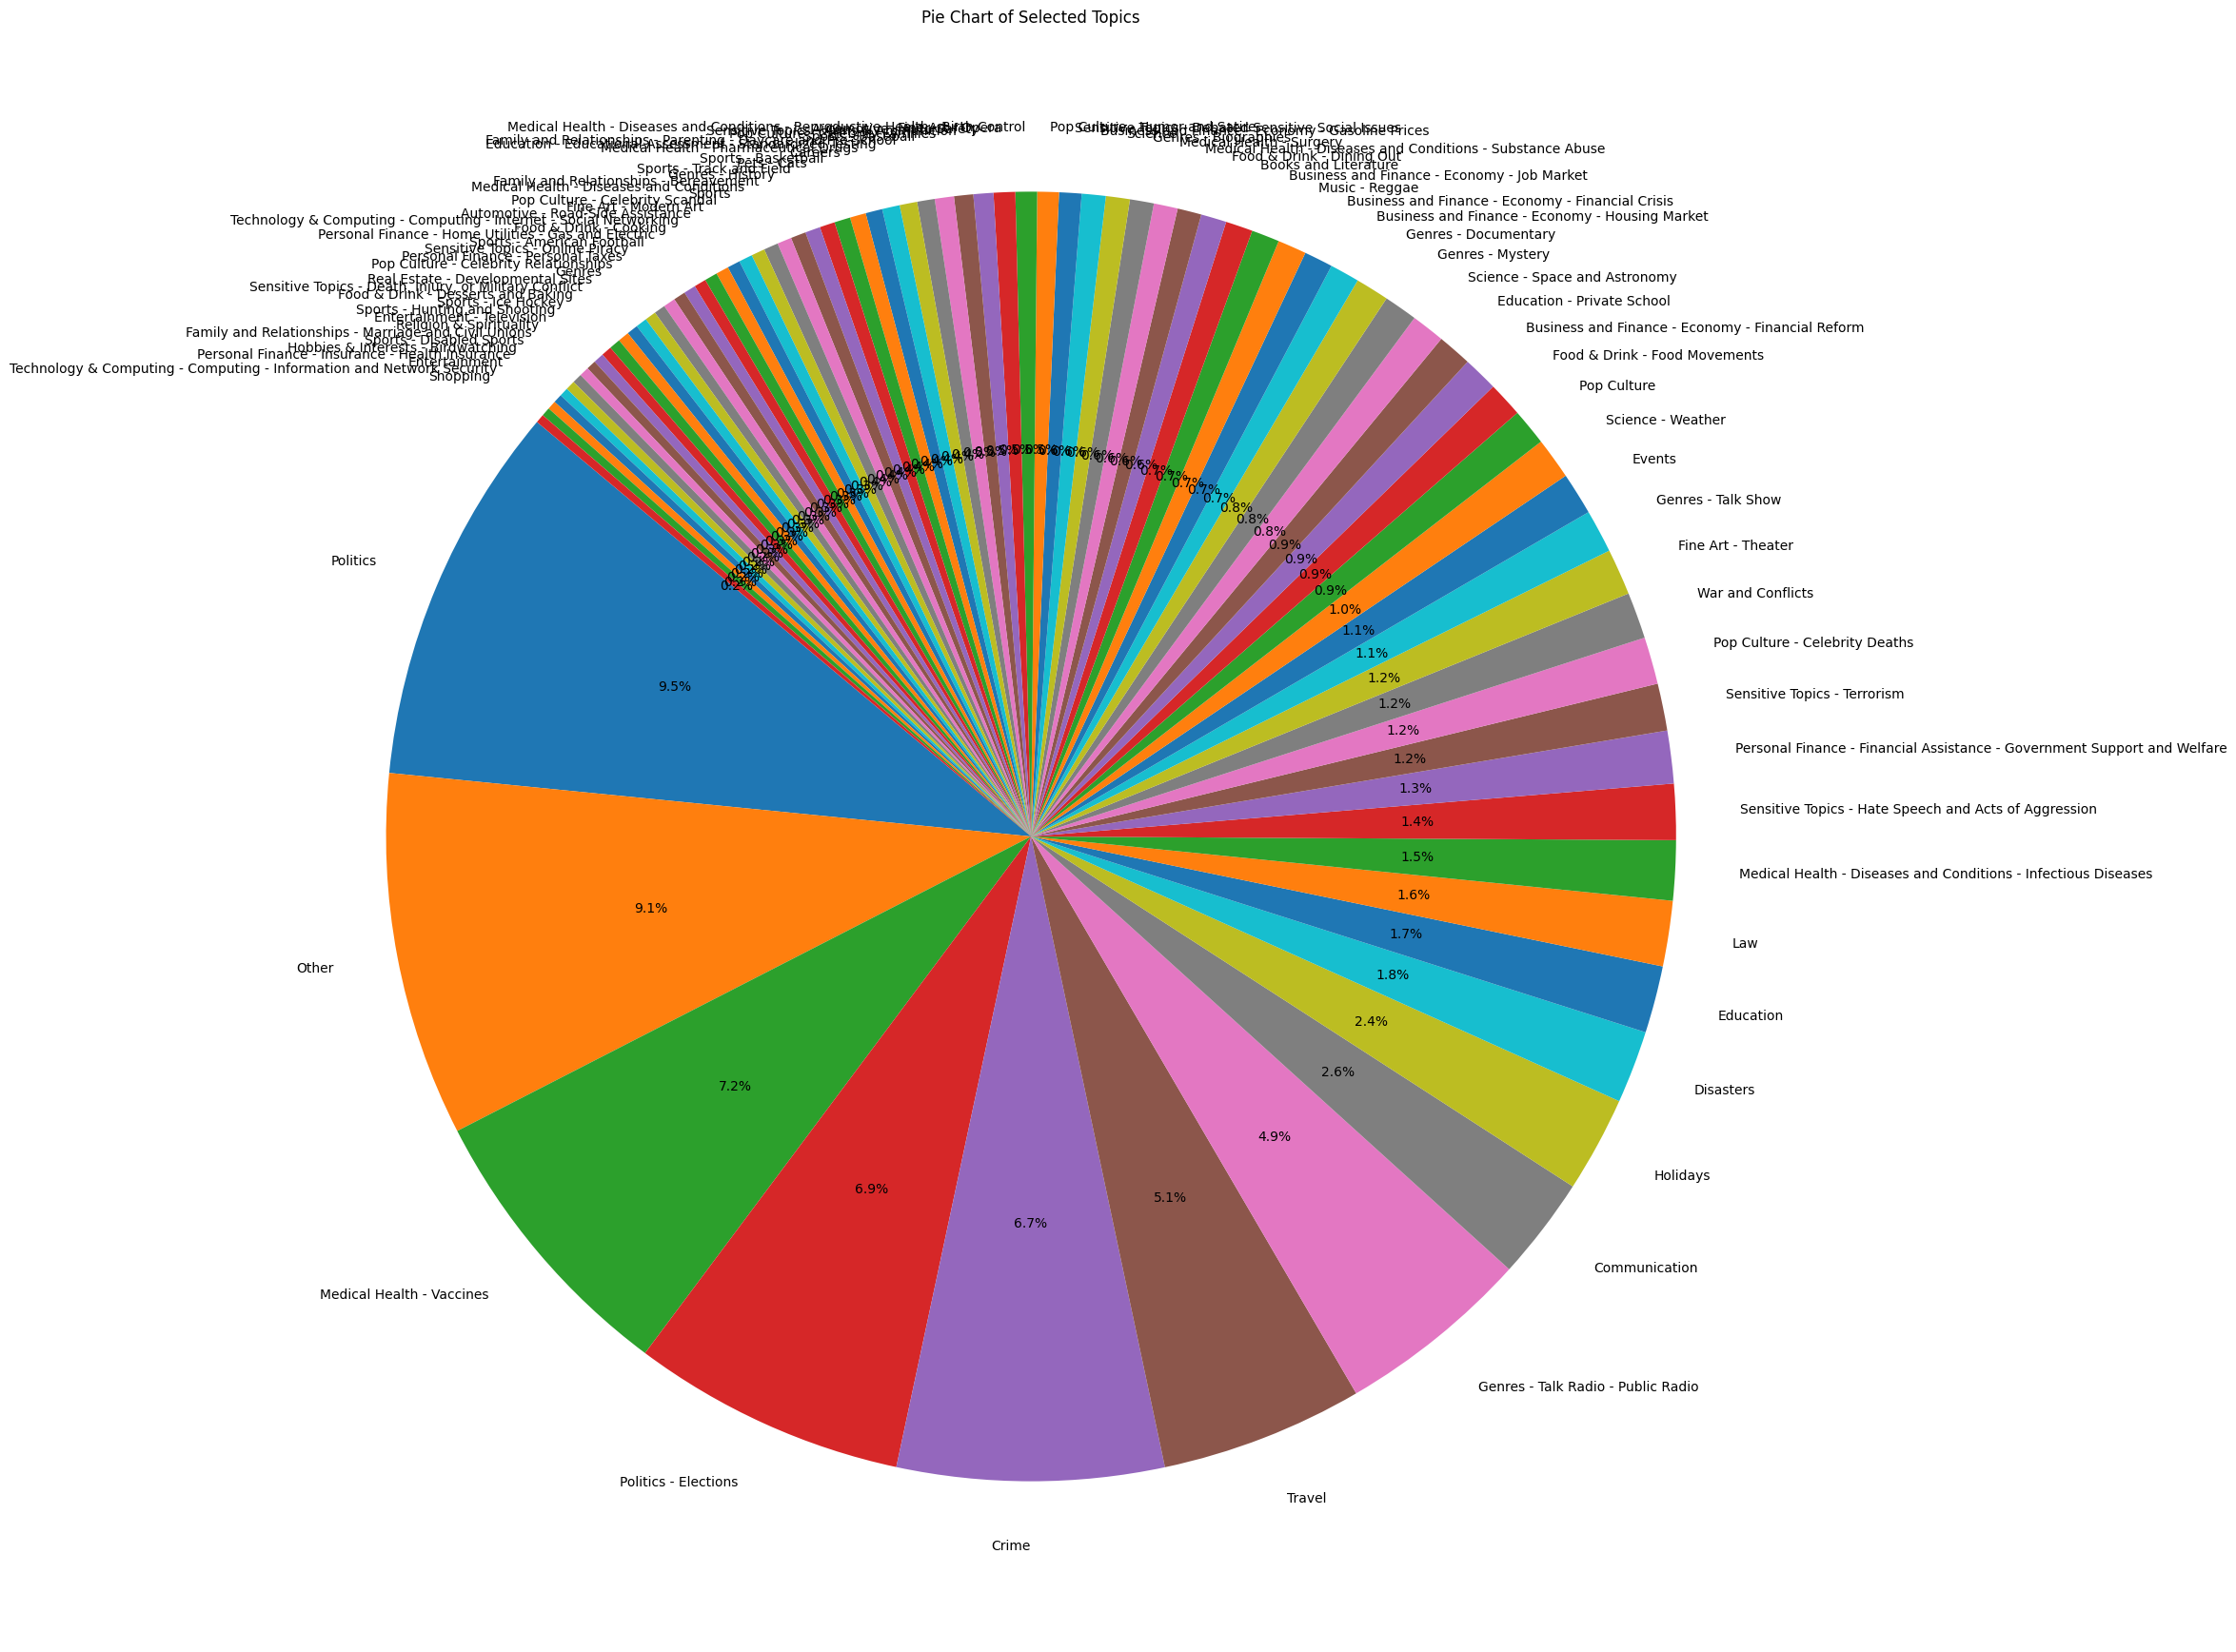

closest_topic_all
Politics                                                                                   442
Politics - Elections                                                                       338
Medical Health - Vaccines                                                                  330
Crime                                                                                      314
Genres - Talk Radio - Public Radio                                                         219
                                                                                          ... 
Sports - Weightlifting                                                                       1
Holidays - National & Civic Holidays                                                         1
Medical Health - Diseases and Conditions - Endocrine and Metabolic Diseases - Menopause      1
Shopping - Coupons and Discounts                                                             1
Music - Variety (Music and Audio

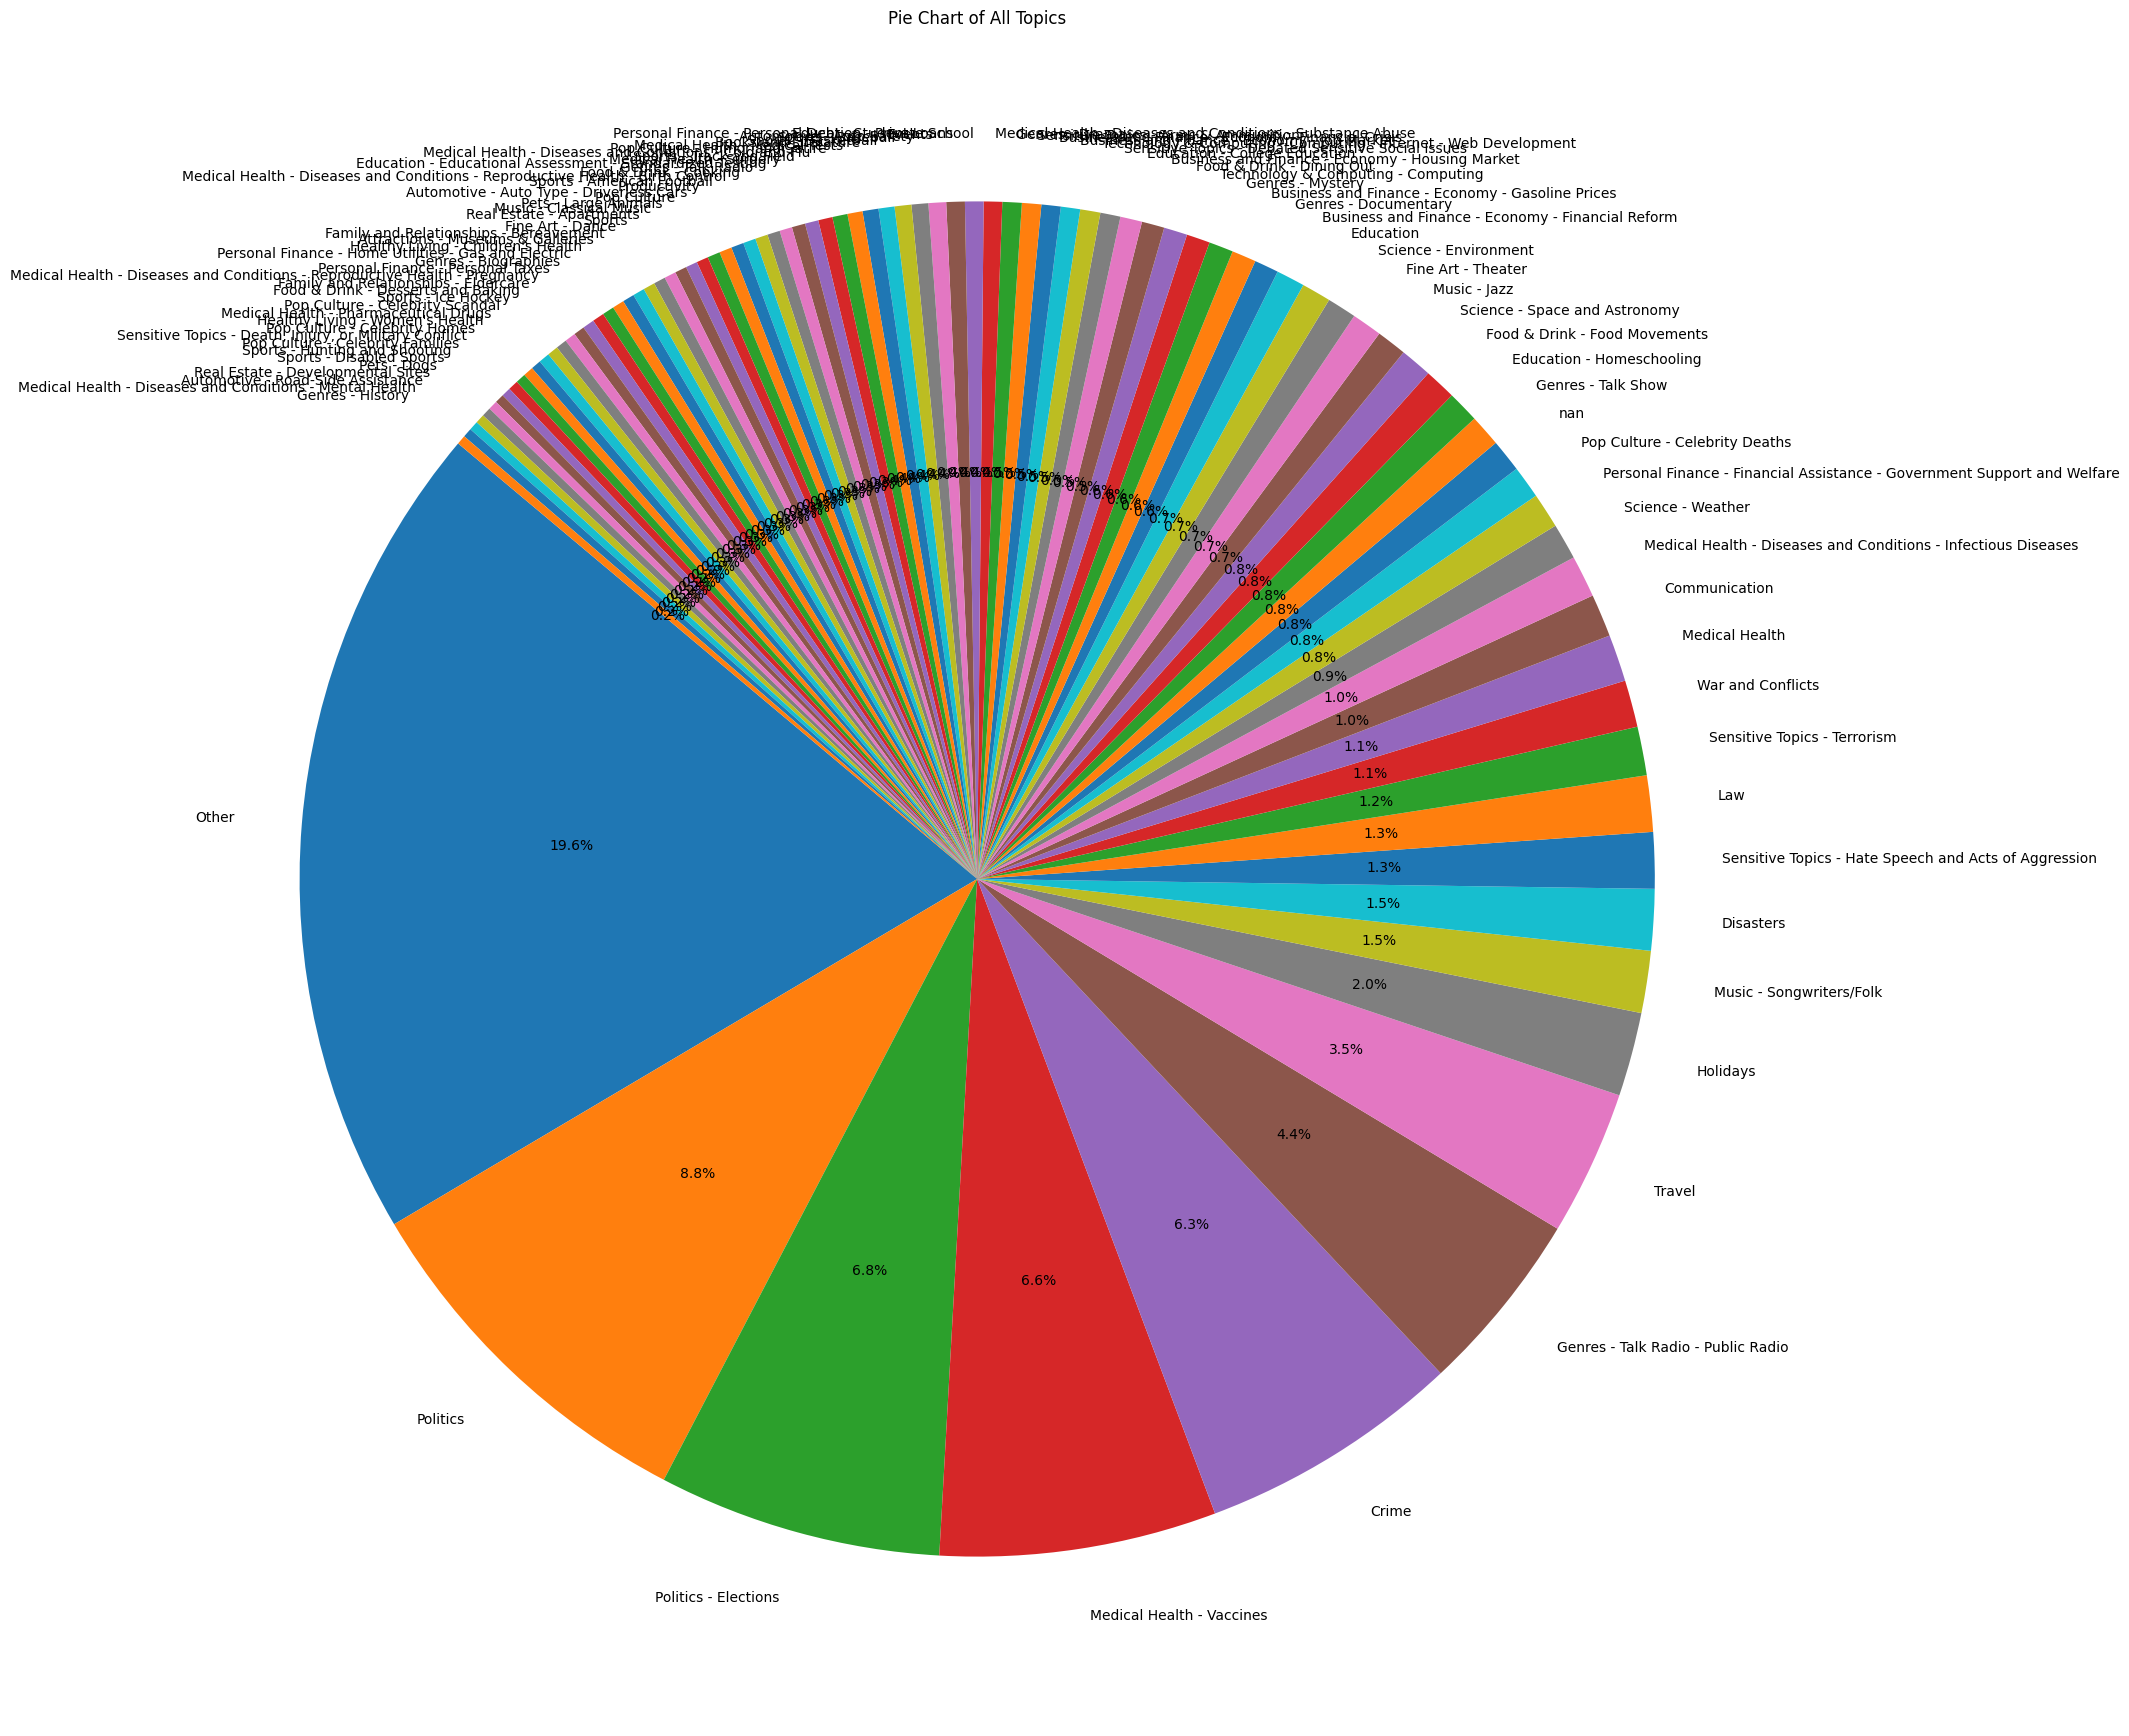

There are 3811 matching labels in 5000 articles. The ratio is 76.22%.


In [45]:
# Analysis on labels from two lists
selected_series = unseen_articles['closest_topic_selected']

# Get the value counts
selected_counts = selected_series.value_counts()
print(selected_counts)
# Identify categories with count 1
categories_to_combine = selected_counts[selected_counts <= 10].index

# Create a new category name for combined values
new_category_name = 'Other'

# Replace categories with count 1 with the new category
selected_series = selected_series.apply(lambda x: new_category_name if x in categories_to_combine else x)

# Create a pie chart
plt.figure(figsize=(22, 22))
plt.pie(selected_series.value_counts(), labels=selected_series.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Selected Topics')
plt.show()


all_series = unseen_articles['closest_topic_all']

# Get the value counts
all_counts = all_series.value_counts()
print(all_counts)
# Identify categories with count 1
categories_to_combine = all_counts[all_counts <= 10].index

# Create a new category name for combined values
new_category_name = 'Other'

# Replace categories with count 1 with the new category
all_series = all_series.apply(lambda x: new_category_name if x in categories_to_combine else x)

# Create a pie chart
plt.figure(figsize=(22, 22))
plt.pie(all_series.value_counts(), labels=all_series.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of All Topics')
plt.show()

count_matching_rows = len(unseen_articles[unseen_articles['closest_topic_all'] == unseen_articles['closest_topic_selected']])
print(f'There are {count_matching_rows} matching labels in {len(unseen_articles)} articles. The ratio is {count_matching_rows/len(unseen_articles)*100}%.')